<a href="https://colab.research.google.com/github/shariarnabil/-CNN-based-AP-selection-task-in-Cell-Free-Massive-MIMO-networks./blob/main/CDF_Untitled36.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
# -------------------------------
# 2. Load channel gain matrix BETAA
# -------------------------------
mat_data = loadmat('BETAA.mat')
beta_matrix = mat_data['BETAA']  # shape: (num_aps, num_users)
signal_strengths = beta_matrix.T  # shape: (num_users, num_aps)
num_users, num_aps = signal_strengths.shape

# -------------------------------
# 3. Compute AP correlation matrix
# -------------------------------
ap_correlation = np.corrcoef(signal_strengths.T)  # shape: (num_aps, num_aps)

In [3]:
# -------------------------------
# 4. Smart AP selection function
# -------------------------------
def select_aps_smart(user_signal, corr_matrix, num_aps_to_select=3, alpha=0.7):
    num_total_aps = len(user_signal)
    norm_gain = (user_signal - np.min(user_signal)) / (np.max(user_signal) - np.min(user_signal) + 1e-8)
    selected_aps = []
    candidate_aps = list(np.argsort(norm_gain)[::-1])

    while len(selected_aps) < num_aps_to_select and candidate_aps:
        scores = []
        for ap in candidate_aps:
            avg_corr = np.mean([abs(corr_matrix[ap, s]) for s in selected_aps]) if selected_aps else 0
            score = alpha * norm_gain[ap] - (1 - alpha) * avg_corr
            scores.append(score)
        best_idx = np.argmax(scores)
        selected_ap = candidate_aps[best_idx]
        selected_aps.append(selected_ap)
        candidate_aps.remove(selected_ap)
    return selected_aps


In [4]:
# -------------------------------
# 5. Select APs for each user
# -------------------------------
X_selected = []
Y_target = []

for user in range(num_users):
    user_signal = signal_strengths[user]
    selected_indices = select_aps_smart(user_signal, ap_correlation, num_aps_to_select=3, alpha=0.7)
    X_selected.append(user_signal[selected_indices])
    Y_target.append(user_signal)

X_selected = np.array(X_selected)
Y_target = np.array(Y_target)

In [5]:
# -------------------------------
# 6. Normalize Data (Z-score)
# -------------------------------
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_selected_scaled = scaler_X.fit_transform(X_selected)
Y_target_scaled = scaler_Y.fit_transform(Y_target)

X_tensor = torch.tensor(X_selected_scaled, dtype=torch.float32)
Y_tensor = torch.tensor(Y_target_scaled, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
# -------------------------------
# 7. Define Regressor Network
# -------------------------------
class APRegressorMLP(nn.Module):
    def __init__(self, input_dim=3, output_dim=num_aps):
        super(APRegressorMLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [7]:
# -------------------------------
# 8. Train the Model
# -------------------------------
model = APRegressorMLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loss_history = []

for epoch in range(100):
    epoch_loss = 0
    for xb, yb in train_loader:
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

Epoch 0, Loss: 0.929122
Epoch 10, Loss: 0.983450
Epoch 20, Loss: 1.111686
Epoch 30, Loss: 0.869619
Epoch 40, Loss: 0.791273
Epoch 50, Loss: 0.885903
Epoch 60, Loss: 0.732338
Epoch 70, Loss: 0.800619
Epoch 80, Loss: 0.823911
Epoch 90, Loss: 0.824747


In [8]:
# -------------------------------
# 9. Evaluation - Top-5 Accuracy
# -------------------------------
correct_count = 0

with torch.no_grad():
    predicted_scaled = model(X_tensor).numpy()
    predicted_ap_gains = scaler_Y.inverse_transform(predicted_scaled)

for i in range(num_users):
    true_best_ap = np.argmax(Y_target[i])
    pred_top5_aps = np.argsort(predicted_ap_gains[i])[::-1][:5]
    if true_best_ap in pred_top5_aps:
        correct_count += 1

coverage_percent = (correct_count / num_users) * 100
print(f"\nTop-5 APs from prediction cover the actual best AP in {coverage_percent:.2f}% of users")


Top-5 APs from prediction cover the actual best AP in 35.00% of users


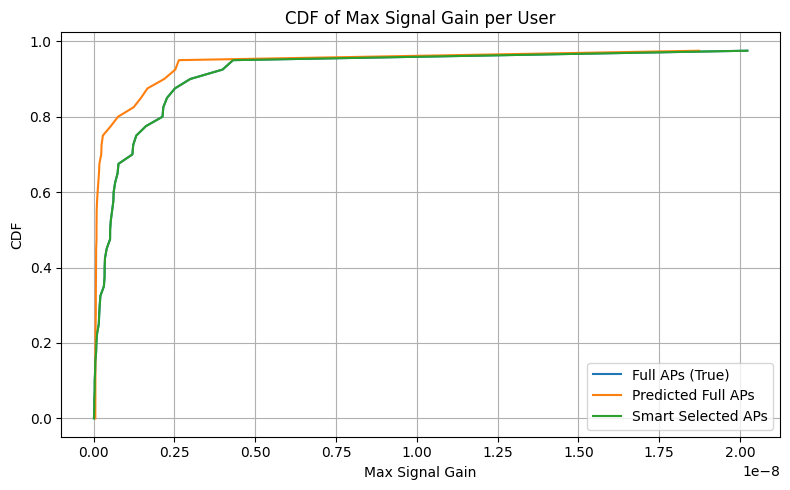

In [9]:
# -------------------------------
# 10. CDF Plot (Properly Scaled)
# -------------------------------
def plot_cdf(data_list, labels, title):
    plt.figure(figsize=(8, 5))
    for data, label in zip(data_list, labels):
        sorted_data = np.sort(data)
        cdf = np.arange(len(sorted_data)) / len(sorted_data)
        plt.plot(sorted_data, cdf, label=label)
    plt.xlabel("Max Signal Gain")
    plt.ylabel("CDF")
    plt.grid(True)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

max_gain_true = np.max(Y_target, axis=1)
max_gain_pred = np.max(predicted_ap_gains, axis=1)
max_gain_selected = np.max(X_selected, axis=1)

plot_cdf(
    [max_gain_true, max_gain_pred, max_gain_selected],
    ["Full APs (True)", "Predicted Full APs", "Smart Selected APs"],
    "CDF of Max Signal Gain per User"
)


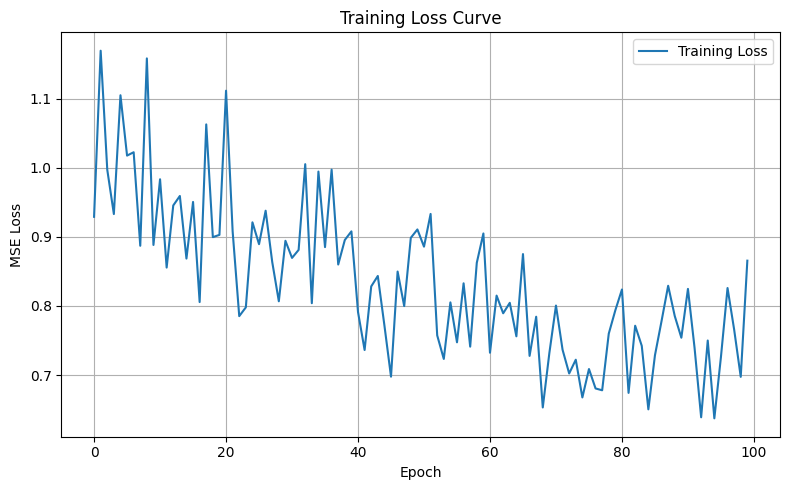

In [10]:
# -------------------------------
# 11. Loss Plot
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()